In [6]:
import torch.nn as nn
import torch
# Define the model
model = nn.Linear(10, 5)  # Example module

# Define the loss function (with default settings)
loss_fn = nn.CrossEntropyLoss()

# Compute the loss
x = torch.randn(2, 10)  # Example input
y = torch.LongTensor([[2, 0, 4, 1]])  # Example target
loss = loss_fn(model(x), y)
print(loss)

tensor(2.0075, grad_fn=<NllLossBackward0>)


In [37]:
import torch.nn.functional as F
import torch

criterion = torch.nn.BCEWithLogitsLoss()
pred = torch.tensor([[0, 0, 0],[1,1,1]],  dtype=torch.float)  # 模型输出的预测得分
true_label = torch.tensor([[0, 0, 0],[1,1,1]], dtype=torch.float)  # 真实标签
loss = criterion(pred.view(1, -1), true_label.view(1, -1))  # 计算多标签交叉熵损失
print(loss)  # tensor(0.4821)

a = torch.tensor([[1],[0],[1],[1]])
a.size(0)
b = torch.eq(a.view(a.size(0),1), a.view(1,a.size(0))).int()
print(b)


a = torch.tensor([1,0,1,1])


tensor(0.5032)
tensor([[1, 0, 1, 1],
        [0, 1, 0, 0],
        [1, 0, 1, 1],
        [1, 0, 1, 1]], dtype=torch.int32)


Some weights of BertModel were not initialized from the model checkpoint at /home/linzhisheng/Digital_Research/SimCSE-main/result/my-sup-simcse-bert-base-uncased-test and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Topic  Size
1      1    32
0      0    22
1: [('breaking', 0.03672139095879898), ('000', 0.03390778668728734), ('payments', 0.032131971425239304), ('https', 0.028522526729484212), ('time', 0.02676270146200152)]
0: [('twitter', 0.04558517498333666), ('know', 0.03988796452788328), ('https', 0.03835788077413394), ('crypto', 0.03432489404651446), ('btc', 0.03322266388386396)]


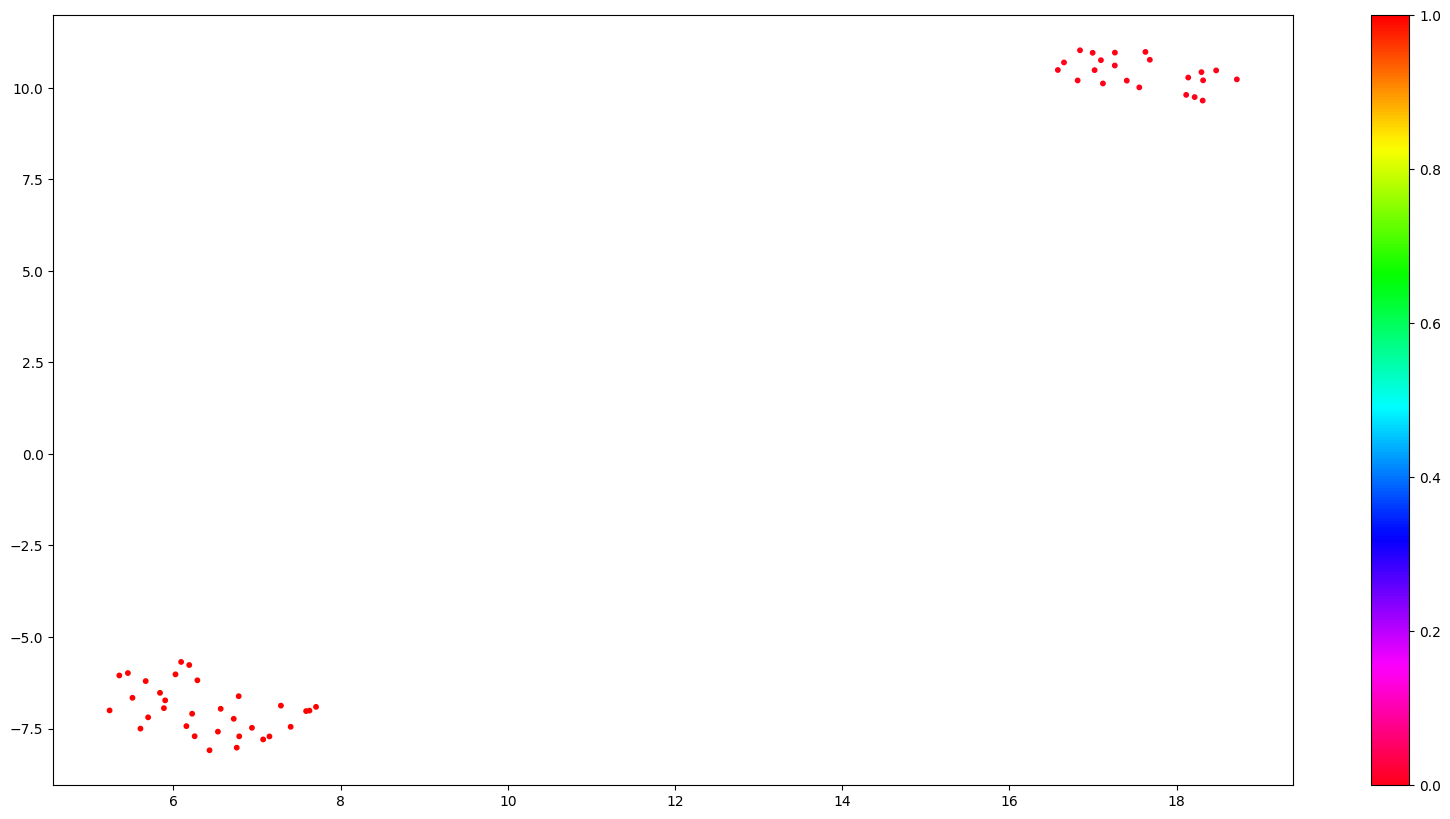

In [44]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
from transformers import pipeline
from keybert import KeyBERT
from flair.embeddings import TransformerDocumentEmbeddings
import pandas as pd
import torch
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from transformers.pipelines import pipeline
from bertopic import BERTopic
from transformers import AutoModel, AutoTokenizer

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def cluster_model(input, output, min_cluster_size, embeddings):
    # embeddings = model.encode(input, show_progress_bar=True)
    # model = AutoModelForMaskedLM.from_pretrained(local)
    # feature_pipeline = pipeline('feature-extraction', model=model, tokenizer = tokenizer)
    # embeddings = feature_pipeline(['good', 'bad'])
    # model = SentenceTransformer('distilbert-base-nli-mean-tokens')
    import umap
    umap_embeddings = umap.UMAP(n_neighbors=15, 
                                n_components=2, 
                                metric='cosine').fit_transform(embeddings)
    import hdbscan
    cluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                            metric='euclidean',                      
                            cluster_selection_method='eom').fit(umap_embeddings)
    
    import matplotlib.pyplot as plt

    # Prepare data
    umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = cluster.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='hsv_r')
    plt.colorbar()
    plt.savefig(output)
    
    
    docs_df = pd.DataFrame(input, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(input))
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=5)
    topic_sizes = extract_topic_sizes(docs_df)
    print(topic_sizes.head(10))
    for t in topic_sizes.head(10)['Topic']:
        print(f"{t}: {top_n_words[t]}")
        

data = pd.read_csv(
    '/home/linzhisheng/Digital_Research/filter_model/data/label_tweets.csv')
# data2 = pd.read_csv(
    # '/home/linzhisheng/Digital_Research/filter_model/data/filter_model_validate_set.csv')
# data = pd.concat([data, data2], ignore_index=True)
texts = data["full_text"].tolist()


MODEL_PATH = '/home/linzhisheng/Digital_Research/SimCSE-main/result/my-unsup-simcse-bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
device = 'cuda:0'
model = AutoModel.from_pretrained(MODEL_PATH).to(device)
inputs = tokenizer(texts, padding=True,
                   truncation=True, return_tensors="pt").to(device)
# # Get the embeddings
with torch.no_grad():
    embeddings = model(**inputs, output_hidden_states=True,
                       return_dict=True).pooler_output.cpu()
    
cluster_model(texts, 'test', 2, embeddings)



In [27]:
topic_model.get_topic(0)

False

In [28]:
topic_model.visualize_topics()

IndexError: arrays used as indices must be of integer (or boolean) type

In [29]:
topic_model.visualize_barchart(top_n_topics=8)

ValueError: 
The 'rows' argument to make_suplots must be an int greater than 0.
    Received value of type <class 'int'>: 0

In [30]:
topic_model.visualize_hierarchy(top_n_topics=50)

ValueError: Found array with 0 sample(s) (shape=(0, 891)) while a minimum of 1 is required by check_pairwise_arrays.